# A Look into Baby Names

## PART A: data wrangling

The task is to get the baby name data from Social Security Adminstration website. Extract the data and perform analysis.  

### Question 1:  Are data clean?

First of all, the data needs to be downloaded as shown by the following blocks of codes. The compressed zipfile downloaded contains 51 text file. Each file contains the comma separated values for state, gender, year, name, and name counts. Only name counts than are greater or equal to 5 are kept for privacy protection purpose. Annotation file is also included for data explanation. I will do some exploratory analysis.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import scipy as sp
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
#The following function is used to get the absolute path from the relative one
import os
def localpath(path):
    return 'file://' + os.path.join(os.path.abspath(os.path.curdir), path)

In [3]:
!mkdir ./babydata

In [4]:
#download the data and store in the local folder
import zipfile, urllib
url = 'http://www.ssa.gov/oact/babynames/state/namesbystate.zip'
urllib.request.urlretrieve(url, './babydata/namesbystate.zip')

('./babydata/namesbystate.zip', <http.client.HTTPMessage at 0x7fe14ba7a438>)

In [5]:
#extract all the data into the folder
z = zipfile.ZipFile('./babydata/namesbystate.zip')
z.extractall('./babydata')

I decided to go with the spark route for handling the data because the laziness
of the evaluation, which doesn't load into the memory when it is not necessary. Furthermore, spark framework provide some nice online learning capabilities if needed.

SQL approach is also feasible, which I might show as another version of this analysis in the later section.

With that being said, the run enviroment do have to have the spark set up before running the following codes.

In [6]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField
sc = SparkContext("local[*]", "name_df")
sqlContext = SQLContext(sc)

In [7]:
#define the schema of the dataframe and extract the info into it
schema = StructType([
    StructField("state", StringType()),
    StructField("sex", StringType()),
    StructField("year", IntegerType()),
    StructField("name", StringType()),
    StructField("freq", IntegerType())
])

df = sqlContext.read.csv(localpath('./babydata/*.TXT'),header=False,schema=schema)

In [8]:
df.printSchema()

root
 |-- state: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- freq: integer (nullable = true)



I will first see how many data are missing and how many data are wrong entries by messing the capital letters in the names.

In [9]:
#How many missing data are there? Apparently none of the entry has missing value
missing = df.count()-df.dropna(how='any').count()
print(missing)

0


In [10]:
#Are there wrong Entries by missing any capital letters in the name? Apparently no.
capital = (df.agg(F.countDistinct('name')).collect()[0][0] -
           df.withColumn('namelower',F.lower(df.name))
             .agg(F.countDistinct('namelower')).collect()[0][0]) #counting distinct names before and after lower the names
print(capital)

0


**Answer 1:**

The data are clean. Although the first 5 years of entries might have some problems, which can only be revealed in the later analysis.

### Question 2: The most popular names of all time for either gender?

In [11]:
##What's the popular names of all time of either gender?

from pyspark.sql.window import Window
#first aggregate the name counts over all year
all_year = (df.groupby('sex','name')
              .agg(F.sum('freq').alias('count'))
              .orderBy(F.col('count').desc()))
#find the max name counts by sex using the window function
w = Window.partitionBy('sex')
favor_name = (all_year.withColumn('max',F.max('count').over(w))
                      .where(F.col('count')==F.col('max'))
                      .select('sex','name'))
(favor_name.toPandas())

,sex,name
0,F,Mary
1,M,James


In [12]:
#The following is the equavilent SQL query 
df.registerTempTable('table')
q = '''SELECT 
             sex, name 
       FROM
             (SELECT 
                  sex, name, count,
                  MAX(count) over (PARTITION BY sex) as maxname 
              FROM
                 (SELECT 
                        sex, name, SUM(freq) as count 
                  From 
                        table 
                  GROUP BY 
                        sex, name 
                  )
             ) 
       WHERE 
             count = maxname
    '''
sqlContext.sql(q).show()

+---+-----+
|sex| name|
+---+-----+
|  F| Mary|
|  M|James|
+---+-----+



**Answer 2:**

The results shows that **Mary** is the all time favorite girls' name while **James** is for boys.

### Question 3: Most ambiguous names in 1945 and 2013

**First trial :**

In order to find out the ambiguity, we need to find out the names that appeared at the same number of times between male and female in 1945 and 2013. First, the aggregated name counts across the whole nation in 1945 and 2013 is separated into two tables--one for male, the other for female. The two tables are then joined together to match the same year and name. After that, the absolute difference of name counts between the two genders is calculated. Finally, the names with zero difference are chosen with the results ordered by year and counts in descending order.

In [13]:
#please see the annotation below for explanation of the syntax
q = '''SELECT 
            year, name, count, diff
       FROM
            (SELECT f.year, f.name, f.count, ABS(f.count-m.count) as diff
            FROM
                 (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        sex = 'F' AND (year = 2013 or year = 1945)
                  GROUP BY 
                        year, name
                  ) as f
                INNER JOIN
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        sex = 'M' AND (year = 2013 or year = 1945)
                  GROUP BY 
                        year, name
                  ) as m
                ON
                      f.year = m.year AND
                      f.name = m.name)
        WHERE
            diff = 0
        ORDER BY
            year, count desc 
        
    '''
sqlContext.sql(q).show(100)

+----+------+-----+----+
|year|  name|count|diff|
+----+------+-----+----+
|1945| Maxie|   19|   0|
|2013|Nikita|   47|   0|
|2013|  Cree|   11|   0|
|2013|Devine|   10|   0|
|2013| Sonam|    5|   0|
|2013| Arlin|    5|   0|
+----+------+-----+----+



**Answer 3 (first trial) :**  

Here are the results:

- 1945: **Maxie**
- 2013: **Nikita, Cree, Devine, Sonam, Arlin**

It appears that all those names are not among the popular names (with the most counts at only 47), which makes me think about a better alternative to find the more appropriate answers. I will try to use the total name counts to smooth out the difference and look for the names with medium to high popularity.

In [14]:
#As you might have already noticed that the names picked are rared
#which gives little information. I would like to try something different.
#This time I will use the total name counts to average the difference.

df.registerTempTable('table')
q = '''SELECT 
            year, name, total,
            diff/total as ratio
       FROM
            (SELECT f.year, f.name, f.count, 
                    ABS(f.count-m.count) as diff,
                    (f.count + m.count) as total 
            FROM
                 (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        sex = 'F' AND (year = 2013 or year = 1945)
                  GROUP BY 
                        year, name
                  ) as f
                INNER JOIN
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        sex = 'M' AND (year = 2013 or year = 1945)
                  GROUP BY 
                        year, name
                  ) as m
                ON
                      f.year = m.year AND
                      f.name = m.name)
        WHERE
            diff/total < 0.083 AND
            total > 2000
        ORDER BY
            year, total desc 
        
    '''
sqlContext.sql(q).show()

+----+-------+-----+-------------------+
|year|   name|total|              ratio|
+----+-------+-----+-------------------+
|1945| Leslie| 3655|0.08125854993160055|
|2013|Charlie| 2848|0.08216292134831461|
+----+-------+-----+-------------------+



**Answer 3 (Update) :**

Instead of counting the absolute value of difference, I decide to use the total name counts of each name to smooth out the popularity. I think that a total name counts of greater than 2000 a year defines a reasonable threshold for popular names. Furthermore, I believe that a small deviation from the expected value is perfectly fine in this case. I chose to use 0.083 according to my trial and error. This threshold set (total > 2000 and ratio/ 0.083) give a unique name in different years. Here are the results:

- 1945: **Leslie**
- 2013: **Charlie**

I think this updated version is more meaningful than the previous trial because I have never met a Maxie in my life so far. 

### Question 4: Increase and decrease in popularity after 1980

In order to calculate the popularity change, the first thing is to select
the entries that are after 1980, summarize the total counts of each name year
pair across the whole nation (groupby year, name) as the numeriator. 
To get the percentage information, the total name counts each year is
calculated (groupby by year) as the denominator. One caveat for the dataset is 
there are some names apprears one year over the 18 year period. Those
entries are deleted by (max_percent <> min_percent). Min and Max values are 
separated into two tables for the following processing.

In [15]:
#This block of code calculates the min value table as described above

q = ''' SELECT name as min_name, year as min_year, min_percent
        FROM
        (SELECT name, year, percentage,
               MAX(percentage) over (PARTITION BY name) as max_percent,
               MIN(percentage) over (PARTITION BY name) as min_percent
        FROM
            (SELECT year, name, count, total,
               (count/total)*100 as percentage
            FROM
                (SELECT 
                       year, name, count,
                       SUM(count) over (PARTITION BY year) as total
                FROM
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        year >= 1980
                  GROUP BY 
                        year, name
                  ORDER BY
                        year)))) as t
        WHERE
            max_percent <> min_percent AND
            percentage = min_percent
    '''
min_table = sqlContext.sql(q)

In [16]:
#This block of code calculates the max value table as described above

q = ''' SELECT name as max_name, year as max_year, max_percent
        FROM
        (SELECT name, year, percentage,
               MAX(percentage) over (PARTITION BY name) as max_percent,
               MIN(percentage) over (PARTITION BY name) as min_percent
        FROM
            (SELECT year, name, count, total,
               (count/total)*100 as percentage
            FROM
                (SELECT 
                       year, name, count,
                       SUM(count) over (PARTITION BY year) as total
                FROM
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        year >= 1980
                  GROUP BY 
                        year, name
                  ORDER BY
                        year)))) as t
        WHERE
            max_percent <> min_percent AND
            percentage = max_percent
    '''
max_table = sqlContext.sql(q)

In [17]:
#spark version to handle the table joining and processing

#Join the two tables together, calculates whether the popularity is increased 
#or decreased. Calculate the percentage change. Order the result by percentage
#change descendingly. Take the 1st data which is the max value in the table.

increase = (min_table.join(max_table,min_table.min_name == max_table.max_name,'inner')
             .withColumn('increase', 
                         F.when(F.col('max_year')>F.col('min_year'),1)
                          .otherwise(-1))
             .withColumn('change',(F.col('max_percent')-F.col('min_percent'))*F.col('increase'))
             .select('min_name','change')
             .orderBy(F.desc('change'))
             .take(1))

#Only difference is taking the ordering ascendingly at the very last step
#in order to get the min value
decrease = (min_table.join(max_table,min_table.min_name == max_table.max_name,'inner')
             .withColumn('increase', 
                         F.when(F.col('max_year')>F.col('min_year'),1)
                          .otherwise(-1))
             .withColumn('change',(F.col('max_percent')-F.col('min_percent'))*F.col('increase'))
             .select('min_name','change')
             .orderBy('change')
             .take(1))

In [18]:
#This block of codes are the SQL equivalent of the above spark codes
#First register the tables obtained above as the min_table and max_table
min_table.registerTempTable('min_table')
max_table.registerTempTable('max_table')

#Join the min_table and max_table together on the same names
#The idea is to get the years associated with the min/max values
#in order to determine increase or decrease in popularity
#To extract the max value, the final table is sorted by percentage change
#reversely. Then, take the 1st number as the max. Min value is vice versa.

q = '''SELECT 
            name, change
       FROM
           (SELECT 
                name,
                (max_percent - min_percent) * increase as change
           FROM
            (SELECT 
                min_name as name,
                max_percent, min_percent,
                CASE WHEN max_year>min_year THEN 1
                     ELSE -1
                     END as increase
            From
                min_table as a JOIN
                max_table as b
                ON
                  min_name = max_name))
       ORDER BY
            change DESC
       LIMIT 1
       
    '''

increase = sqlContext.sql(q).collect()
#The following code is for extracting the min value for the percentage change
q = '''SELECT 
            name, change
       FROM
           (SELECT 
                name,
                (max_percent - min_percent) * increase as change
           FROM
            (SELECT 
                min_name as name,
                max_percent, min_percent,
                CASE WHEN max_year>min_year THEN 1
                     ELSE -1
                     END as increase
            From
                min_table as a JOIN
                max_table as b
                ON
                  min_name = max_name))
       ORDER BY
            change
       LIMIT 1
       
    '''

decrease = sqlContext.sql(q).collect()

In [19]:
print("Highest increase: {}".format(increase[0][0]),
      "Increased by: {}%".format(increase[0][1]),
      "Highest decrease: {}".format(decrease[0][0]),
      "Decreased by: {}%".format(decrease[0][1]),sep='\n')

Highest increase: Tyler
Increased by: 0.8684475806399412%
Highest decrease: Jennifer
Decreased by: -1.8354295883706977%


**Answer 4:**


Here are the results based on the calculations:

- Highest increase: **Tyler**
- Increased by: 0.8684475806399412%
- Highest decrease: **Jennifer**
- Decreased by: -1.8354295883706977%

One caveat for this analysis lies in the assumption that max() and min() function can find the GLOBAL maxima and minima. However, in the real world, this is not often the case. We can verify Tyler and Jennifer by plotting their popularities over time.

In [20]:
#this block of codes extract the information for 'Tyler' and 'Jennifer'
#to verify their signals (max/min values) are extracted correctly.

q = '''
        (SELECT year, name,
               (count/total)*100 as percentage
            FROM
                (SELECT 
                       year, name, count,
                       SUM(count) over (PARTITION BY year) as total
                FROM
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        year >= 1980
                  GROUP BY 
                        year, name
                  ORDER BY
                        year))
         WHERE
             name = 'Tyler' OR
             name = 'Jennifer'
         ORDER BY
             name, year)
    '''

Text(0.5,1,'Popularity Changes Over Time')

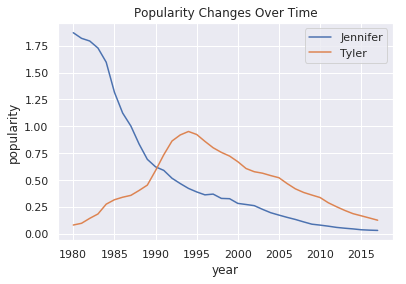

In [21]:
fig, ax = plt.subplots()
(sqlContext.sql(q)
        .toPandas()
        .set_index('year')
        .sort_index()
        .groupby('name')
        .plot(ax=ax))
ax.legend(['Jennifer','Tyler'])
ax.set_ylabel('popularity')
ax.set_title('Popularity Changes Over Time')

The figure seems to be in consistent with our assumption about the global maxima and minima. It is good to have that confidence in the pocket. But still, I haven't exhausted the whole dataset about the pattern...

### Question 5: Increase and decrease in popularity before 1980

Question 5 is asking a similar question as question 4. But this time the time window is shifted to before 1980. The basic strategy is the same. I will use the values of Tyler and Jennifer to filter the final results.

In [22]:
#construct the min table as last question
q = ''' SELECT name as min_name, year as min_year, min_percent
        FROM
        (SELECT name, year, percentage,
               MAX(percentage) over (PARTITION BY name) as max_percent,
               MIN(percentage) over (PARTITION BY name) as min_percent
        FROM
            (SELECT year, name, count, total,
               (count/total)*100 as percentage
            FROM
                (SELECT 
                       year, name, count,
                       SUM(count) over (PARTITION BY year) as total
                FROM
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        year < 1980
                  GROUP BY 
                        year, name
                  ORDER BY
                        year)))) as t
        WHERE
            max_percent <> min_percent AND
            percentage = min_percent
    '''
min_table_early = sqlContext.sql(q)

In [23]:
#construct the max table as last question
q = ''' SELECT name as max_name, year as max_year, max_percent
        FROM
        (SELECT name, year, percentage,
               MAX(percentage) over (PARTITION BY name) as max_percent,
               MIN(percentage) over (PARTITION BY name) as min_percent
        FROM
            (SELECT year, name, count, total,
               (count/total)*100 as percentage
            FROM
                (SELECT 
                       year, name, count,
                       SUM(count) over (PARTITION BY year) as total
                FROM
                  (SELECT 
                        year, name, SUM(freq) as count 
                  From 
                        table 
                  Where
                        year < 1980
                  GROUP BY 
                        year, name
                  ORDER BY
                        year)))) as t
        WHERE
            max_percent <> min_percent AND
            percentage = max_percent
    '''

max_table_early = sqlContext.sql(q)

In [24]:
#join table to look for the name with bigger increase in popularity
min_table_early.registerTempTable('min_table_early')
max_table_early.registerTempTable('max_table_early')

q = '''SELECT 
            name, change
       FROM
           (SELECT 
                name,
                (max_percent - min_percent) * increase as change
           FROM
            (SELECT 
                min_name as name,
                max_percent, min_percent,
                CASE WHEN max_year>min_year THEN 1
                     ELSE -1
                     END as increase
            From
                min_table_early as a JOIN
                max_table_early as b
                ON
                  min_name = max_name))
       WHERE
            change > 0.8684475806399412
       ORDER BY
            change DESC
    '''

increase_early = sqlContext.sql(q).collect()

In [25]:
#join table to find names with harder drops in popularity
q = '''SELECT 
            name, change
       FROM
           (SELECT 
                name,
                (max_percent - min_percent) * increase as change
           FROM
            (SELECT 
                min_name as name,
                max_percent, min_percent,
                CASE WHEN max_year>min_year THEN 1
                     ELSE -1
                     END as increase
            From
                min_table_early as a JOIN
                max_table_early as b
                ON
                  min_name = max_name))
       WHERE
            change < -1.8354295883706977
       ORDER BY
            change
    '''

decrease_early = sqlContext.sql(q).collect()

In [26]:
increase_list = [a[0] for a in increase_early]
decrease_list = [b[0] for b in decrease_early]
print("Even bigger increase: {}".format(', '.join(increase_list)),
      "Even deeper decrease: {}".format(', '.join(decrease_list)),sep='\n\n')

Even bigger increase: Linda, Michael, Jennifer, Robert, David, Jason, Christopher, Lisa, Richard, Patricia, Mark, Deborah, Donald, Debra, Brian, Susan, Carol, Matthew, Amy, Melissa, Gary, Ronald, Michelle, Amanda, Sandra, Kimberly, Joshua, Judith, Karen, Larry, Steven, Cynthia, Scott, Sharon, Jeffrey, Jessica, Donna, Timothy, Heather

Even deeper decrease: Mary, Shirley, Helen


**Answer 5:**

The algorithm is the same as the previous question. The differences are: 

1. Changing the year filter to before 1980;
2. Changing the finding the max/min value to set values.

The results show that there were ***39 names*** had even larger increase while **Mary, Shirley, Helen** dropped in popularity even harder than Jennifer does in recent years.  

## PART B: machine learning and prediction

### Time series analysis

The dataset could be potentially very helpful in guidance the manufacturing of the baby products. If we can find a way to predict the number of new borns and adjust the production/marketing strategies, that will give the manufacturer a great advantage. So, the target of the following analysis will be on: 1) Is there a time-dependent trend in the new born rates showing in the data? 2) How well can we predict the number of new borns? 3) Are there any other datasets available to improve this analysis?

Let's start with the first question. 

As an easy start, we will look at the new born names across the whole nation. We can worry about the regional differences later.

In [27]:
import pandas as pd
pop = (df.groupby('year')
         .sum('freq')
         .withColumnRenamed('sum(freq)','population'))
pop.show(5)

+----+----------+
|year|population|
+----+----------+
|1959|   3955206|
|1990|   3567015|
|1975|   2744585|
|1977|   2882836|
|1924|   2218862|
+----+----------+
only showing top 5 rows



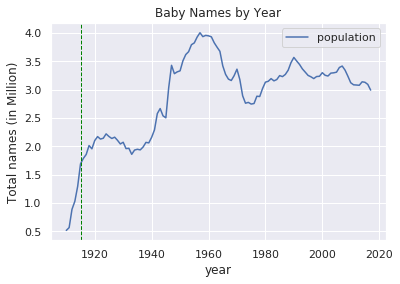

In [28]:
baby = pop.toPandas()
(baby.set_index('year')
    .sort_index()
    .eval('population = population / 1000000')
    .plot())
plt.ylabel('Total names (in Million)')
plt.title('Baby Names by Year')
plt.axvline(1915,color = 'green',ls = 'dashed',lw = 1)

From this exploratory figure, we can clearly see the periodic signal in the new born rates. This reflects very well the [three baby booms] (https://en.wikipedia.org/wiki/Baby_boom) in the American history. The first 5 data points from 1910 to 1914 has very sharp increase which doesn't fit with the rest of the dataset. It might be the first few years of name registration implementation. For the consistency of the analysis, I will exclude those 5 years from the further analysis.

#### Modeling base line

We all know that population grows in the [exponential growth function] (https://en.wikipedia.org/wiki/Exponential_growth). I will first use the exponential fit to get the baseline. The population takes the log transformation, then is fitted again the time which is converted to the Julian date. A constant field is added into the feature for the linear regressor.

In [29]:
#selecting only the year after 1914
baby = baby[baby.year > 1914]
baby['year'] = pd.to_datetime(baby.year,format="%Y")
baby = baby.set_index('year',drop=True).sort_index()
baby['julian'] = baby.index.to_julian_date()

#adding a constant field into the feature for the linear regressor
def add_constant(X):
    X['const'] = pd.Series(np.ones(len(X.index)), index=X.index)
    return X
baby = add_constant(baby)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
#The dataset will be split into train and test sets for cross validation
#linear model is chosen because of the exponential growth function
#and the benefit of downstream analysis
X_train,X_test,y_train,y_test = train_test_split(baby[['julian','const']], 
                                                 baby.population, 
                                                 test_size=0.1, random_state=42)
parameters = {'alpha':[0.1, 1, 10]}
exponential_model = GridSearchCV(Ridge(), parameters, cv=5)
exponential_model.fit(X_train,np.log(y_train))#target needs log transformation

score = r2_score(np.log(y_test),exponential_model.predict(X_test))
print("R2 score: {}".format(score),
      "Best parameters: {}".format(exponential_model.best_params_),sep = '\n')

R2 score: 0.3423270103477085
Best parameters: {'alpha': 10}


Text(0,0.5,'population')

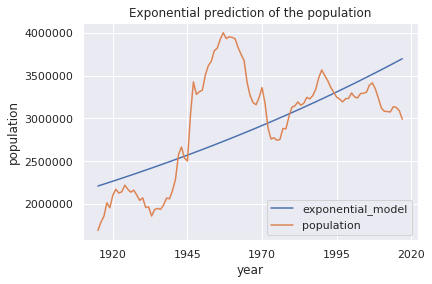

In [31]:
#The baseline signal is substracted from the original signal
#The log residuals (log_error_exponential) are for further analysis
exp_model_df = baby
exp_model_df['exponential_model'] = np.exp(exponential_model
                                          .predict(baby[['julian','const']]))
exp_model_df['log_error_exponential'] = np.log(
                                exp_model_df['population'] /exp_model_df['exponential_model'])
exp_model_df[['exponential_model','population']].plot();
plt.title('Exponential prediction of the population')
plt.ylabel('population')

The fit isn't good with a terrible R2 score (0.3423). I have also tried a polynomial fit by adding the square of julian date. The results were much better with a R2 score at 0.67. However, in line with the following seasonality analysis, I will keep the first model simple.

#### Modeling Error

Since we get the baseline taken care of, we can move on to model the seasonality. First, we need to take a look at the residuals.

Text(0.5,1,'Log Residuals Show Periodicity')

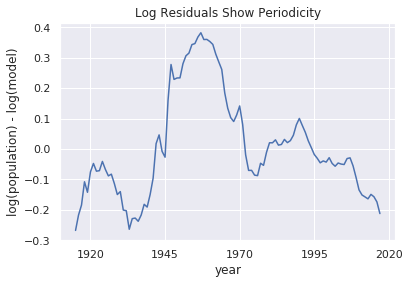

In [32]:
(exp_model_df.log_error_exponential).plot()
plt.ylabel('log(population) - log(model)')
plt.title('Log Residuals Show Periodicity')

Indeed, the residuals show some kind of periodicity that has three peaks in the signal. I will do a Fourier transform to find out the frequencies.

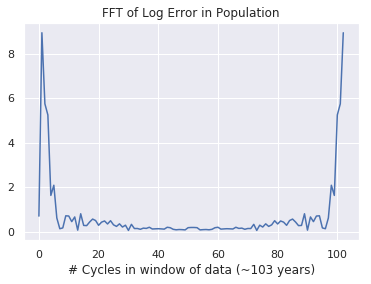

In [33]:
from scipy import fftpack

fft = fftpack.fft(baby['log_error_exponential'])
plt.plot(np.abs(fft))
plt.title('FFT of Log Error in Population')
plt.xlabel('# Cycles in window of data (~103 years)');

Well, what this figure tells us is that there is no rigid periodical signal in the total baby names over time. Theoretically, I can do sin() and cos() transformation of the julian date into the feature spaces if the seasonality signal is strong. In this case, however, I will try to use the moving average instead.

First, let's verify if the signal autocorrelates with itself.

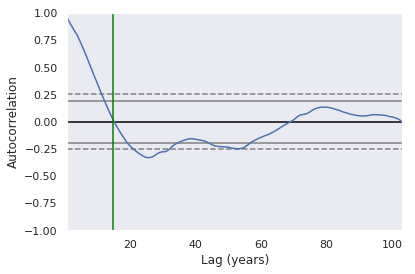

In [34]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(baby['log_error_exponential'])
plt.xlabel('Lag (years)')
plt.axvline(15, color = 'green');

Indeed, there is autocorrelation in the residuals. The characteristic time scale (the point that signal crosses x axis) for the residuals is 15 years, indicating by the green solid line. That means we should only look at population data up to 15 years to predict the future population. 

I would like to predict 1 year in the future because knowing 1 year in advance should give the manufacture a great leverage in the market. 

In [35]:
PREDICTION_LAG = 1 # in year
#To keep the model simple, I will save the most recent 10 years for test
CUT = 2008

#creating the 'future' value by shifting the population
baby['future'] = (baby['population'].shift(-PREDICTION_LAG)
                                   .fillna(method = 'ffill'))

I would like to build a model to predict the residuals of the exponential model 1 year out, from the last and current residuals, as well as 3 years rolling averages for the population and its derivative.

count    6.000000
mean    -0.000096
std      0.017400
min     -0.027117
25%     -0.007360
50%     -0.000333
75%      0.011094
max      0.022009
dtype: float64


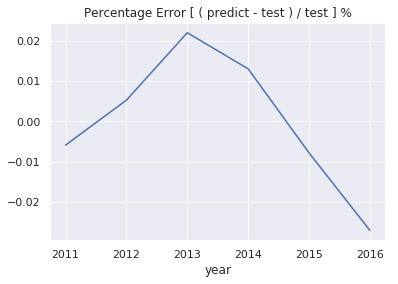

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import base
#last 10 points saved for testing
train = baby[baby.index < datetime(CUT,1,1)]
test = baby[baby.index >= datetime(CUT,1,1)]

# Reporting function
def summarize_errors(test_me):
    error_pct = (test_me['future'] - test_me['model']) / test_me['future']

    print(error_pct.describe())
    error_pct.plot()
    plt.title('Percentage Error [ ( predict - test ) / test ] %')
    plt.show()
    

# Helper funtion to take care of the feature engineering
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['log_error_exponential'] #current residual
    feats['LEE_1'] = frame['log_error_exponential'].shift(1) #last residual
    #moving average of population derivative
    feats['dLEE_avg'] = pd.Series.rolling(frame['population'].diff(), 
                                          window=3*PREDICTION_LAG).mean()
    #variance of log error exponential in 3 years period
    feats['vol_avg'] = pd.Series.ewm(frame['population'], 
                                     span=3*PREDICTION_LAG).var(bias=False)
    #future log error exponential
    feats['future_LEE'] = frame['log_error_exponential'].shift(-PREDICTION_LAG)
    return feats.dropna(how='any')

#Customized estimator to fit and predict the log error
class CustomEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def fit(self, X, y=None):
        self.model = []
        feats = frame_to_feats(X)
        #split the X and y after they have been processed together
        X_train = feats.drop('future_LEE', axis=1).values
        y_train = feats['future_LEE'].values
        #this takes care of the time series forward chaining validation
        tss = TimeSeriesSplit(n_splits=5).split(X_train)
        #RandomForest gives a good estimate
        parameters = {'n_estimators':[10, 50, 100]}
        regress = GridSearchCV(RandomForestRegressor(), 
                               param_grid=parameters, cv=tss)
        self.model = regress.fit(X_train,y_train)
        return self
    
    def predict(self, X):
        feats = frame_to_feats(X)
        X_test = feats.drop('future_LEE', axis=1).values
        return self.model.predict(X_test)
    
predicted = CustomEstimator().fit(train).predict(test)
#take care of the data alignment
test = test[-predicted.shape[0]-1:-1]
test['predicted_LEE'] = predicted
#total predicted value from base exponential model and the error model
test['model'] = np.exp(test['predicted_LEE']) * test['exponential_model']

# Report
test_me = test[['future', 'model']].dropna(how='any')
summarize_errors(test_me)

From the results above, we can see that the prediction is roughly within 3 % of the real population number. Considered that there are only 103 data points, the model actually did a reasonably good job. 

### Combining external features

Now that we have a somewhat solid fundation, we need to think about how we can do better. As mentioned earlier, we only have 103 data points. And, we built our model in the assumption that future population value depends only on the previous ones, which is not the case at all. Other factors also play important roles like the population migration both on the nation level and the state level. We will need to get the census data to extract those information. The migration census data can be obtained from the [website] (https://www.census.gov/data/tables/time-series/demo/geographic-mobility/historic.html). We can put in the inmigration and outmigration numbers as the feature and put them into our model to see if the predition power of our model improves.  

### Other Thoughts

There are other ways we can leveage the baby name dataset: 

1. Region / Division / State levels of analysis: I haven't got the time to touch on those areas. Those sub-regional information can provide a great guidance on inventory management and marketing expense allocation, etc. Analysis can be done on different parameters like names, gender, total population, etc.

2. Analysis on the names: imagine that we have a manufacturer who makes name tags. If the relative frequency of different names are known ahead of time, the company can save a lot of materials on producing the not so popular products. The regional analysis mentioned above guides the inventory management in different sub-markets.

3. Gender analysis: Although we know that male/female ratio should be around 0.5 with strong biological evidence, sub-region difference still exists. Say a baby toy manufacturer wants to know how many boy vs girl versions of toys need to produce and how to allocate the product in different regions. Analysis of the gender information in the sub-regional levels can provide a tremendous help in this type of situation. 

4. Anomaly detection: In this case, we can focus on the historical trends of the popularity of different names to see if there is a sudden change on the whole nation or regional levels. Special attention can be paid to the not so popular names in this case. This analysis can give some insights on the migration of the sub-popular names.

There will be many more ways to use this dataset. Those 4 points are the ones I can think of at the moment.

## PART C : *Summary*

To wrap up, the following are the take home messages from this notebook:

1. Baby dataset contains 51 comma separated text file corresponding to each states. No missing data or capital letter mishandling are found. First 5 years data increase too rapidly. They are excluded from the analysis in Part B.

2. **Mary** is the all time favorite girls' name while **James** is for boys.

3. The most ambiguous name taking into consideration of popularity in 2013 is **Charlie**. In 1945, that is **Leslie**.

4. **Tyler** has the largest percentage increase (although dropped in recent year) since 1980. **Jennifer** has the largest percentage decrease at the same period.

5. **Mary, Shirley, Helen** had even larger decrease in popularity than Jennifer before 1980. There were 39 names having larger increase in popularity than Tyler before 1980.

6. Time series analysis on the name counts in the whole nation shows three baby booms in consistent with the American history. 

7. Base line of the population is fitted with exponential model.

8. The residuals from the exponential model show no rigid periodicity. Residuals have autocorrelation up to 15 years.

9. The residuals are fitted with the moving average to predict 1 year ahead of time. Forward chaining cross validation is used to train the model. The combined model provides decent population estimation in recent years. 

10. The analysis can be improved by combining the data from US Census data.

11. There are 4 ways of other usage of this dataset I can propose at the moment. 


Last note on the code implementation. I have chosen to use the spark dataframe to take the advantage of the laziness of evaluation, capability of combining SQL syntax, and future proof. I provided two versions of codes, one for the dataframe while the other for SQL query, for question 2. Question 1 is done in dataframe. Question 3, 4, 5 are done in SQL queries (with a small portion of alternation in the latter part). The whole Part A can be, in fact, done with just SQL queries. I have used the window function in my SQL queries, which is not supported by SQLite. 


Thank you very much for taking your time reading this. Hopefully, there are some useful information you can take home.

In [37]:
sc.stop()